In [1]:
######################################################################
# N.B. Requires python environment with packages installed and       #
#      This script requires hard coded links                         #
#                                                                    #
#           Loads Phylobayes formatted trees and analyzes node ages  #
#                                                                    #
# © MIT EAPS Fournier Lab Jack G. Payette E: payette@mit.edu         #                   
#                                                                    #
######################################################################

In [2]:
#Not all of these packages are needed, but they're good to have and you might need to install them!
import ete3
import pandas as pd
import re
import multiprocessing
import itertools
import random
import collections
import operator
import os
from scipy import stats
import numpy as np
import pymc3
import seaborn as sns
import arviz
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator,FormatStrFormatter,AutoMinorLocator)
# Data stored to disk using pickle
import pickle as pkl 

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
#Example installation call -- you may need to use pip,pip3,conda,miniconda to install
#
# ! pip install arviz
#  returns: Requirement already satisfied: arviz in /home/payette/.conda/envs/py37/lib/python3.7/site-packages (0.11.0)
#
# Bash:
#
# module add engaging/anaconda/2.3.0 
# conda env list
# conda activate py37
# 

In [4]:
def get_node_age_from_descendants(tree, descendants):
    node = tree.get_common_ancestor(descendants)
    return(node.support)

In [5]:
def get_ci_of_the_mean(data, confidence=0.95):
    degrees_of_freedom = len(data) - 1
    tailed_alpha = (1 - confidence) / 2
    t_stats      = stats.t.ppf(tailed_alpha, degrees_of_freedom)
    std_err      = np.std(data) / np.sqrt( degrees_of_freedom )
    data_mean    = np.mean(data)
    return(data_mean - abs(t_stats * std_err), data_mean + abs(t_stats * std_err))

In [6]:
# Start initializing routine and tree diagnostics
# Load guide tree & label tree
# N.B. guide Tree is not in use in this script.
# ASSUMPTION: ALL DATEDISTS HAVE THE SAME TOPOLOGY

In [7]:
# From nitrilase_609.phy
guide_tree = ete3.Tree('nitrilase_609.phy.treefile.rooted')

In [8]:
print(guide_tree)


               /-tax387_
            /-|
           |   \-tax399_
         /-|
        |  |   /-tax451_
        |   \-|
        |      \-tax460_
        |
        |                     /-tax394_
        |                    |
        |                  /-|      /-tax412_
        |                 |  |   /-|
        |                 |   \-|   \-tax450_
        |               /-|     |
        |              |  |      \-tax443_
        |              |  |
        |              |  |   /-tax402_
        |              |   \-|
        |            /-|     |   /-tax454_
        |           |  |      \-|
        |           |  |         \-tax458_
        |           |  |
        |         /-|  |   /-tax404_
        |        |  |   \-|
        |        |  |      \-tax431_
        |        |  |
        |        |  |   /-tax405_
        |        |   \-|
        |        |     |   /-tax422_
        |        |      \-|
        |        |         \-tax448_
        |        |
        |        | 

In [9]:
#select the first TreeNode object upon traversing the tree in ete and check if is_root?
ete3.TreeNode.is_root(next(guide_tree.traverse()))

True

In [10]:
#Use the ete describe function upon traversing the tree in ete and check if is_root?
ete3.TreeNode.describe(next(guide_tree.traverse()))

Number of leaf nodes:	469
Total number of nodes:	937
Rooted:	Yes
Most distant node:	tax25_
Max. distance:	8.513437


In [11]:
# Load PB label tree
# This is the important label tree that will be the PRIMARY PK
# Use with getAges, loadAges, for the target_node_age object and trees loaded from datedists

In [12]:
phylo_bayes_named_tree = ete3.Tree('Nitrilase_cir_610_prior_wcals_sample.labels', format=1)

In [13]:
print(phylo_bayes_named_tree)


         /-tax447_
      /-|
     |   \-tax406_
     |
     |               /-tax382_
     |            /-|
     |           |   \-tax379_
     |         /-|
     |        |  |   /-tax345_
     |        |   \-|
     |        |      \-tax289_
     |        |
     |        |      /-tax301_
     |        |   /-|
     |        |  |  |   /-tax250_
     |        |  |   \-|
     |        |  |     |   /-tax318_
     |        |  |      \-|
     |        |  |         \-tax236_
     |        |  |
     |        |  |      /-tax258_
     |        |  |     |
     |        |  |     |      /-tax342_
     |      /-|  |     |   /-|
     |     |  |  |     |  |   \-tax286_
     |     |  |  |     |  |
     |     |  |  |   /-|  |      /-tax317_
     |     |  |  |  |  |  |     |
     |     |  |  |  |  |  |   /-|   /-tax257_
     |     |  |  |  |  |  |  |  |  |
     |     |  |  |  |  |  |  |   \-|      /-tax316_
     |     |  |  |  |  |  |  |     |   /-|
     |     |  |  |  |   \-|  |     |  |  |   /-tax359_


In [14]:
ete3.TreeNode.is_root(next(phylo_bayes_named_tree.traverse()))

True

In [15]:
ete3.TreeNode.describe(next(phylo_bayes_named_tree.traverse()))

Number of leaf nodes:	468
Total number of nodes:	935
Rooted:	Yes
Most distant node:	tax460_
Max. distance:	1228.794900


In [16]:
%%capture
for node in phylo_bayes_named_tree.traverse(strategy='preorder'):
    if not node.is_leaf():
         print(node.name)

In [17]:
#%%capture
internal_node_names=[]
for node in phylo_bayes_named_tree.traverse(strategy='preorder'):
    if not node.is_leaf():
         print(node.name)
         internal_node_names.append(node.name)

468
539
540
541
542
576
645
647
646
577
642
643
644
578
607
608
641
609
636
637
638
639
640
610
633
634
635
611
613
629
632
630
631
614
628
615
618
619
622
627
623
624
625
626
620
621
616
617
612
579
606
580
598
605
599
600
604
601
603
602
581
583
586
587
589
596
597
590
593
595
594
591
592
588
584
585
582
543
544
572
573
574
575
545
570
571
546
568
569
547
548
567
549
566
550
551
552
553
554
555
565
556
561
563
564
562
557
558
559
560
648
649
658
664
669
674
676
675
670
671
672
673
665
666
667
668
659
662
663
660
661
650
656
657
651
652
653
654
655
677
678
679
680
681
695
699
725
700
724
701
702
723
703
704
705
720
721
722
706
717
718
719
707
714
716
715
708
713
709
710
711
712
696
697
698
682
685
690
692
693
694
691
686
687
688
689
683
684
726
727
729
730
734
731
733
732
728
735
736
771
772
773
774
775
776
737
738
739
740
746
770
747
769
748
765
768
766
767
749
750
751
752
757
764
758
759
760
761
763
762
753
754
755
756
741
742
743
744
745
777
787
788
789
827
790
802
826
803
804
805


In [18]:
#Possible internal nodes around which to fetch dates
print(internal_node_names,'Total:',len(internal_node_names))

['468', '539', '540', '541', '542', '576', '645', '647', '646', '577', '642', '643', '644', '578', '607', '608', '641', '609', '636', '637', '638', '639', '640', '610', '633', '634', '635', '611', '613', '629', '632', '630', '631', '614', '628', '615', '618', '619', '622', '627', '623', '624', '625', '626', '620', '621', '616', '617', '612', '579', '606', '580', '598', '605', '599', '600', '604', '601', '603', '602', '581', '583', '586', '587', '589', '596', '597', '590', '593', '595', '594', '591', '592', '588', '584', '585', '582', '543', '544', '572', '573', '574', '575', '545', '570', '571', '546', '568', '569', '547', '548', '567', '549', '566', '550', '551', '552', '553', '554', '555', '565', '556', '561', '563', '564', '562', '557', '558', '559', '560', '648', '649', '658', '664', '669', '674', '676', '675', '670', '671', '672', '673', '665', '666', '667', '668', '659', '662', '663', '660', '661', '650', '656', '657', '651', '652', '653', '654', '655', '677', '678', '679', '680'

In [19]:
#Check which node label is the ROOT
#Node labels are stored in target_node_age dictionary for the node age pulled from the PB datadist
temp_root =next(phylo_bayes_named_tree.traverse())
print(temp_root.name)
next(guide_tree.traverse()).is_root()

468


True

In [20]:
##################
# Node labels selected for dates are hard coded!
##################
target_node_ages = {'468':[], '539':[]}
#, '540', '541', '542', '576', '645', '647', '646', '577', '642', '643', '644', '578', '607', '608', '641', '609', '636', '637', '638', '639', '640', '610', '633', '634', '635', '611', '613', '629', '632', '630', '631', '614', '628', '615', '618', '619', '622', '627', '623', '624', '625', '626', '620', '621', '616', '617', '612', '579', '606', '580', '598', '605', '599', '600', '604', '601', '603', '602', '581', '583', '586', '587', '589', '596', '597', '590', '593', '595', '594', '591', '592', '588', '584', '585', '582', '543', '544', '572', '573', '574', '575', '545', '570', '571', '546', '568', '569', '547', '548', '567', '549', '566', '550', '551', '552', '553', '554', '555', '565', '556', '561', '563', '564', '562', '557', '558', '559', '560', '648', '649', '658', '664', '669', '674', '676', '675', '670', '671', '672', '673', '665', '666', '667', '668', '659', '662', '663', '660', '661', '650', '656', '657', '651', '652', '653', '654', '655', '677', '678', '679', '680', '681', '695', '699', '725', '700', '724', '701', '702', '723', '703', '704', '705', '720', '721', '722', '706', '717', '718', '719', '707', '714', '716', '715', '708', '713', '709', '710', '711', '712', '696', '697', '698', '682', '685', '690', '692', '693', '694', '691', '686', '687', '688', '689', '683', '684', '726', '727', '729', '730', '734', '731', '733', '732', '728', '735', '736', '771', '772', '773', '774', '775', '776', '737', '738', '739', '740', '746', '770', '747', '769', '748', '765', '768', '766', '767', '749', '750', '751', '752', '757', '764', '758', '759', '760', '761', '763', '762', '753', '754', '755', '756', '741', '742', '743', '744', '745', '777', '787', '788', '789', '827', '790', '802', '826', '803', '804', '805', '806', '807', '808', '809', '810', '825', '811', '812', '824', '813', '816', '819', '820', '821', '822', '823', '817', '818', '814', '815', '791', '792', '793', '801', '794', '795', '799', '800', '796', '797', '798', '828', '829', '830', '831', '832', '833', '834', '835', '836', '841', '842', '843', '837', '840', '838', '839', '844', '845', '846', '847', '848', '849', '850', '853', '855', '856', '854', '851', '852', '857', '858', '859', '860', '861', '862', '863', '864', '865', '866', '867', '868', '869', '872', '870', '871', '873', '874', '875', '876', '877', '878', '879', '880', '886', '881', '883', '884', '885', '882', '887', '888', '889', '902', '903', '904', '890', '891', '892', '893', '894', '895', '896', '897', '898', '899', '900', '901', '905', '906', '907', '908', '909', '910', '911', '912', '916', '917', '918', '919', '920', '921', '922', '923', '924', '928', '925', '926', '927', '929', '930', '931', '932', '933', '934', '913', '914', '915', '778', '786', '779', '780', '781', '782', '783', '784', '785', '469', '470', '471', '473', '472', '474', '538', '475', '536', '537', '476', '477', '486', '487', '478', '485', '479', '483', '484', '480', '481', '482', '488', '534', '535', '489', '533', '490', '499', '521', '522', '532', '523', '531', '524', '525', '529', '530', '526', '527', '528', '500', '501', '520', '502', '517', '518', '519', '503', '504', '505', '506', '507', '508', '509', '510', '512', '513', '514', '515', '516', '511', '491', '498', '492', '493', '497', '494', '495', '496'] 

In [21]:
print(target_node_ages) 
#prints: {'468': [], '539': []}

{'468': [], '539': []}


In [22]:
def getAges(posterior_trees,model_name):
    # Function inputs:
    # posterior_trees AKA datedist TREES
    # phylo_bayes_named_tree # hard coded
    # target_node_ages # hard coded
    # model_name
    # Careful the line below can take a long time. Use the target_node_ages code above to change the loop!!!

    # Weird way of indexing over these trees, but we don't care which trees we take
    post_tree_index=[]
    n=0
    for each in posterior_trees:
        post_tree_index.append(n)
        n=n+1
    posterior_trees
    print('Length of Datedist',len(posterior_trees))

    target_node_ages = {
                    '468':[], #ROOT
                    '539':[]}
    target_node_descendants = {}

    for node_name in target_node_ages:
        node = next(phylo_bayes_named_tree.iter_search_nodes(name=node_name))
        target_node_descendants[node_name] = node.get_leaf_names()

    for target_node in target_node_ages.keys():
        target_node_ages[target_node].append([])

    for tree_index, target_node in itertools.product(post_tree_index, target_node_ages.keys()):
        target_node_ages[target_node][-1].append(
            get_node_age_from_descendants(
                posterior_trees[tree_index],
                target_node_descendants[target_node]
                )
            )

    #Use this after the long run above
    with open(''+model_name+'_target_node_ages.pkl', 'wb') as out:
            pkl.dump(target_node_ages, out)

    return(target_node_ages)
    print('done')

In [23]:
def loadAges(model_name):
    with open(''+model_name+'_target_node_ages.pkl', 'rb') as into:  
        model_target_node_ages = pkl.load(into)
        #print('Length of Datedist',len(model_target_node_ages[:]))
    return(model_target_node_ages)

In [24]:
###############
### EXAMPLE:  #
###############

In [25]:
Nitrilase_cir_610_posterior_wcals_sample_ages = loadAges('Nitrilase_cir_610_posterior_wcals_sample')

In [26]:
#Length of Datedist loaded
len(Nitrilase_cir_610_posterior_wcals_sample_ages['468'][0])

16960

In [27]:
# Prints an list of node ages (or you can wrap it in an array)
# for a given node label, from a target_node_age dictionary
print(Nitrilase_cir_610_posterior_wcals_sample_ages['468'][0])

[1245.96, 1325.99, 1326.19, 1211.04, 1250.13, 1283.79, 1295.13, 1324.89, 1286.22, 1292.65, 1275.61, 1283.87, 1290.22, 1303.17, 1312.68, 1293.28, 1290.54, 1332.37, 1312.53, 1256.28, 1322.55, 1310.65, 1324.79, 1315.49, 1241.42, 1271.8, 1321.78, 1249.16, 1342.35, 1279.73, 1274.77, 1351.38, 1304.99, 1273.72, 1313.5, 1310.45, 1294.83, 1281.95, 1312.58, 1374.1, 1287.67, 1293.39, 1252.26, 1266.86, 1297.53, 1291.18, 1283.59, 1292.54, 1272.37, 1317.33, 1241.01, 1309.67, 1302.58, 1230.62, 1255.46, 1275.22, 1281.22, 1253.0, 1261.44, 1260.71, 1297.81, 1311.79, 1295.96, 1301.24, 1325.02, 1348.93, 1343.19, 1386.13, 1336.19, 1355.38, 1308.6, 1301.6, 1321.93, 1309.26, 1296.13, 1310.74, 1310.04, 1314.65, 1296.69, 1305.39, 1309.32, 1298.09, 1322.17, 1326.02, 1298.83, 1298.82, 1312.92, 1300.56, 1313.63, 1292.33, 1284.67, 1345.56, 1330.49, 1331.93, 1352.34, 1334.95, 1348.55, 1323.89, 1363.71, 1324.76, 1366.38, 1362.5, 1388.12, 1403.13, 1401.13, 1422.81, 1403.54, 1431.28, 1421.36, 1426.38, 1422.18, 1378.02

In [28]:
########
#
#   
#
########

In [29]:
# IF RUNNING FOR THE FIRST TIME, SKIP TO BOTTOM OF CODE TO RUN FIRST
# OTHERWISE USE .PKL DATA TO LOAD PREVIOUS NODE AGE DATES

In [30]:
### Run the loadAges commands to import pickled files with node age data
# Original scheme w/ 3 models, posterior & prior

In [31]:
##################################################
# Original scheme w/ 3 models, posterior & prior #
##################################################

In [32]:
Nitrilase_cir_610_prior_wcals_ages = loadAges('Nitrilase_cir_610_prior_wcals_sample')

In [33]:
Nitrilase_cir_610_posterior_wcals_ages = loadAges('Nitrilase_cir_610_posterior_wcals_sample')

In [34]:
Nitrilase_ln_610_prior_wcals_sample_ages = loadAges('Nitrilase_ln_610_prior_wcals_sample')

In [35]:
Nitrilase_ln_610_posterior_wcals_sample_ages = loadAges('Nitrilase_ln_610_posterior_wcals_sample')

In [36]:
Nitrilase_ugam_610_prior_withcals_sample_ages = loadAges('Nitrilase_ugam_610_prior_withcals_sample')

In [37]:
Nitrilase_ugam_610_posterior_withcals_sample_ages = loadAges('Nitrilase_ugam_610_posterior_withcals_sample')

In [38]:
### Run the loadAges commands to import pickled files with node age data
# New model scheme "d_" w/ 3 models, posterior & prior

In [39]:
################################
### d_Nitrilase model scheme ###
################################

In [40]:
d_Nitrilase_cir_610_prior_AllCals_new38_sample_ages = loadAges('d_Nitrilase_cir_610_prior_AllCals_new38_sample')

In [41]:
d_Nitrilase_cir_610_post_AllCals_new38_sample_ages = loadAges('d_Nitrilase_cir_610_post_AllCals_new38_sample')

In [42]:
d_Nitrilase_ln_610_prior_AllCals_new38_sample_ages = loadAges('d_Nitrilase_ln_610_prior_AllCals_new38_sample')

In [43]:
d_Nitrilase_ln_610_post_AllCals_new38_sample_ages = loadAges('d_Nitrilase_ln_610_post_AllCals_new38_sample')

In [44]:
d_Nitrilase_ugam_610_prior_AllCals_new38_sample_ages = loadAges('d_Nitrilase_ugam_610_prior_AllCals_new38_sample')

In [45]:
d_Nitrilase_ugam_610_post_AllCals_new38_sample_ages = loadAges('d_Nitrilase_ugam_610_post_AllCals_new38_sample')

In [46]:
########
#
#   
#
########

In [47]:
##################################################
# Original scheme w/ 3 models, posterior & prior #
##################################################

In [48]:
### Plotting routine for original scheme, 3 models, posterior & prior

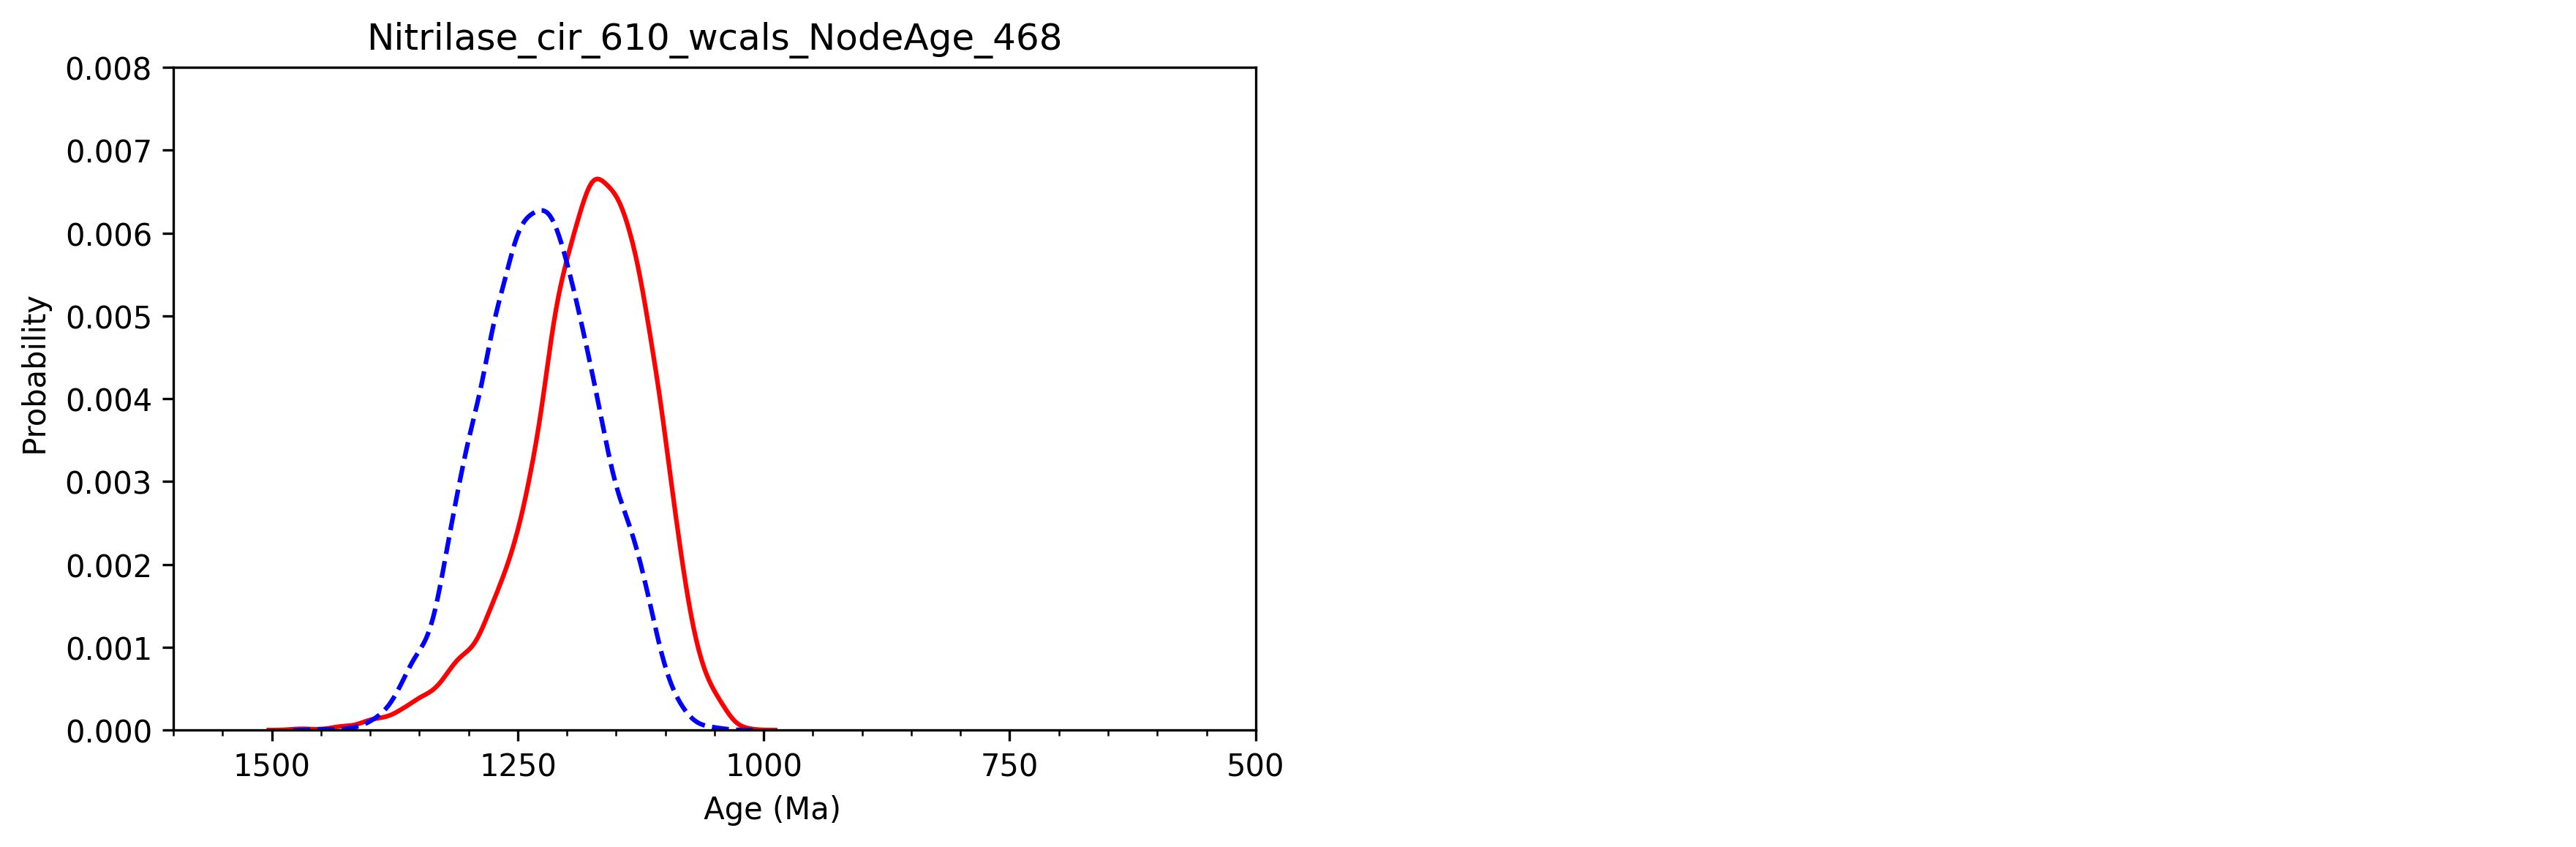

In [49]:
kwargs = {"linewidth" : "1.5"}
fig, axes = plt.subplots(1, 2, figsize=(14,4), sharex=False,sharey=True,dpi=300)

axes[0]=sns.kdeplot(Nitrilase_cir_610_posterior_wcals_ages['468'][0],label="Node ",
                    ax=axes[0],color="red", **kwargs)
axes[0]=sns.kdeplot(Nitrilase_cir_610_prior_wcals_ages['468'][0],label="Node ",
                    ax=axes[0],color="blue",linestyle='--', **kwargs)
#Corrected line style so Blue dashed is the prior and Red solid is posterior

axes[0].set_ylabel("     Probability")
axes[0].set_xlabel("             Age (Ma) ")

### Y-limits 
axes[0].set_ylim([0,0.008])
### X-limits 
axes[0].set_xlim([1600,500])
axes[0].xaxis.set_minor_locator(MultipleLocator(50))
axes[0].xaxis.set_major_locator(MultipleLocator(250))
axes[1].axis('off')
axes[0].title.set_text('Nitrilase_cir_610_wcals_NodeAge_468')
fig.savefig('Nitrilase_cir_610_wcals_NodeAge_468_10_16_22'+'.svg',format='svg')
fig.savefig('Nitrilase_cir_610_wcals_NodeAge_468_10_16_22'+'.png',format='png')

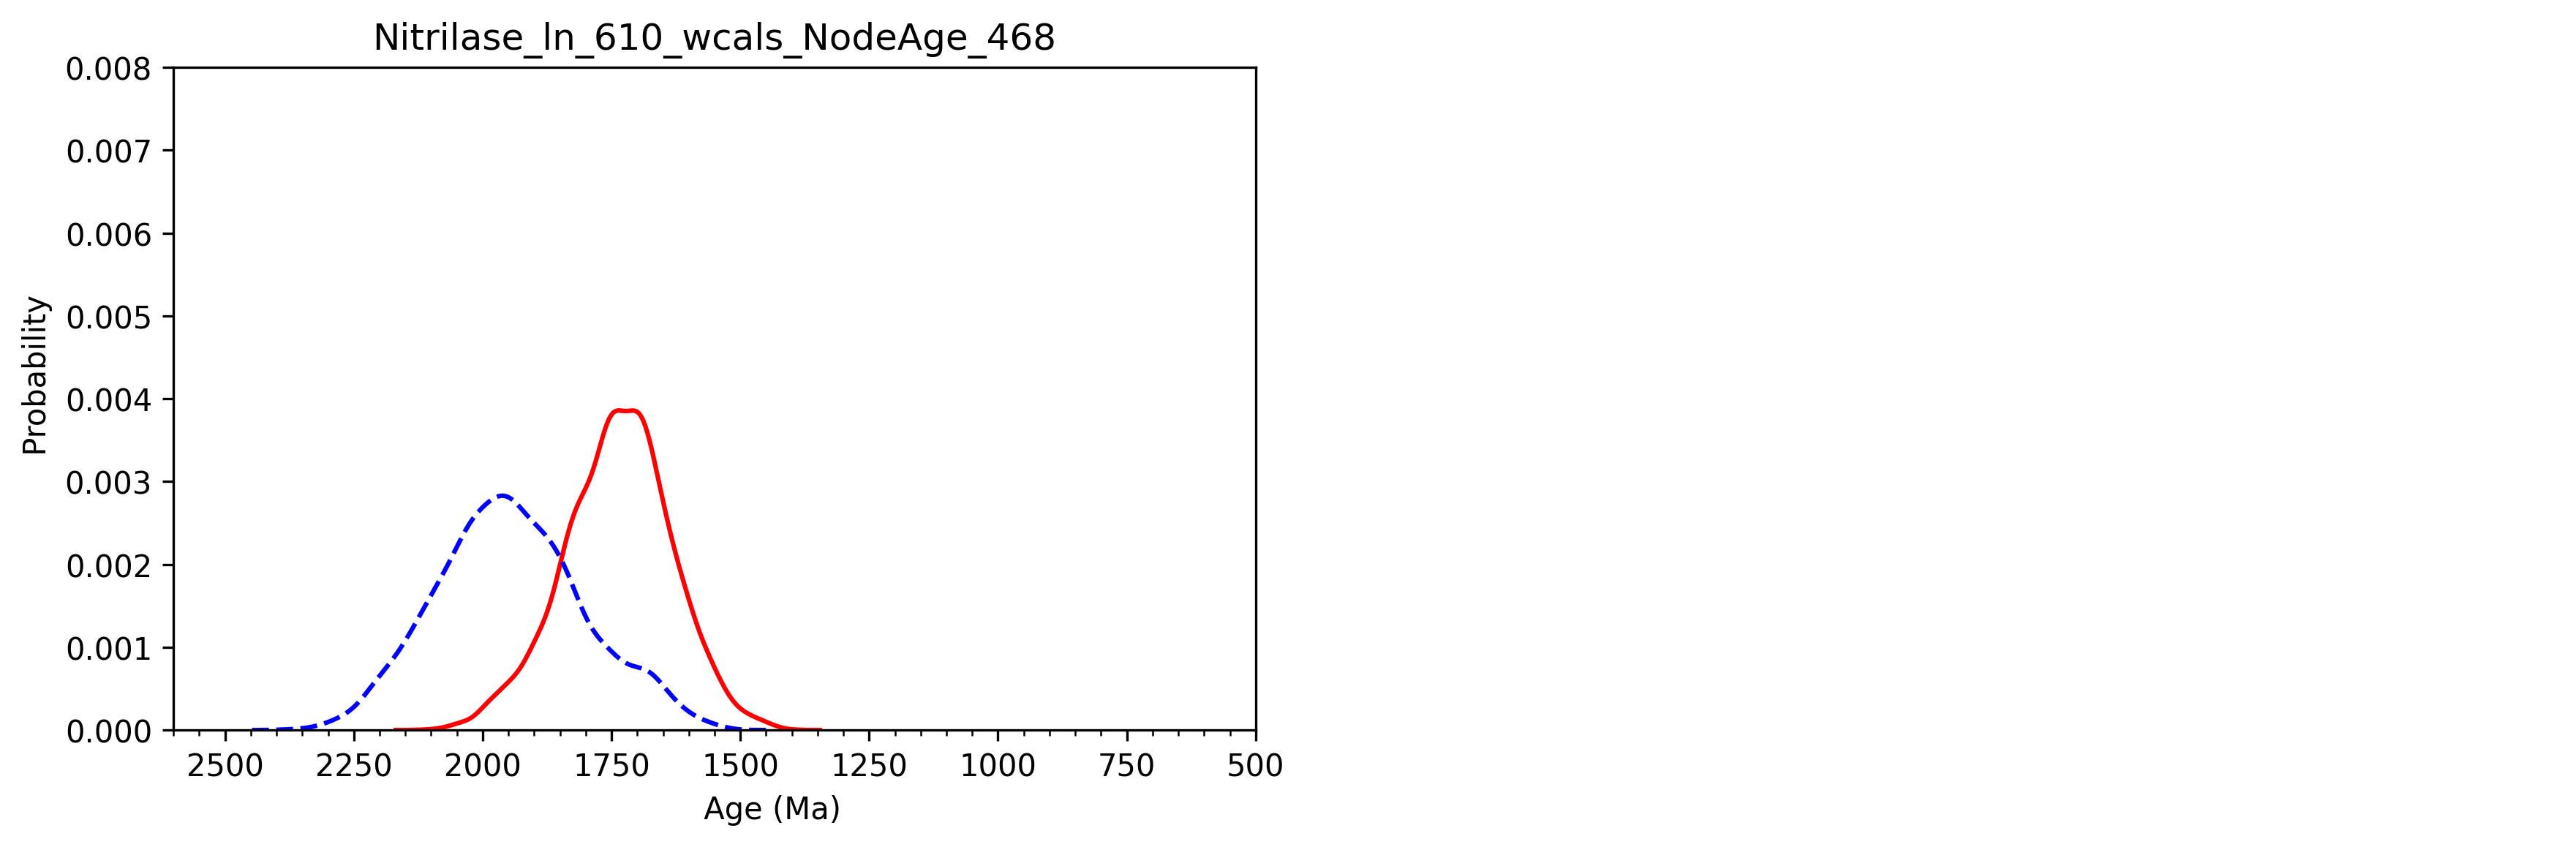

In [50]:
kwargs = {"linewidth" : "1.5"}
fig, axes = plt.subplots(1, 2, figsize=(14,4), sharex=False,sharey=True,dpi=300)

axes[0]=sns.kdeplot(Nitrilase_ln_610_posterior_wcals_sample_ages['468'][0],label="Node ",
                    ax=axes[0],color="red", **kwargs)
axes[0]=sns.kdeplot(Nitrilase_ln_610_prior_wcals_sample_ages['468'][0],label="Node ",
                    ax=axes[0],color="blue",linestyle='--', **kwargs)

axes[0].set_ylabel("     Probability")
axes[0].set_xlabel("             Age (Ma) ")

### Y-limits 
axes[0].set_ylim([0,0.008])
### X-limits 
axes[0].set_xlim([2600,500])
axes[0].xaxis.set_minor_locator(MultipleLocator(50))
axes[0].xaxis.set_major_locator(MultipleLocator(250))
axes[1].axis('off')
axes[0].title.set_text('Nitrilase_ln_610_wcals_NodeAge_468')
fig.savefig('Nitrilase_ln_610_wcals_NodeAge_468_10_16_22'+'.svg',format='svg')
fig.savefig('Nitrilase_ln_610_wcals_NodeAge_468_10_16_22'+'.png',format='png')

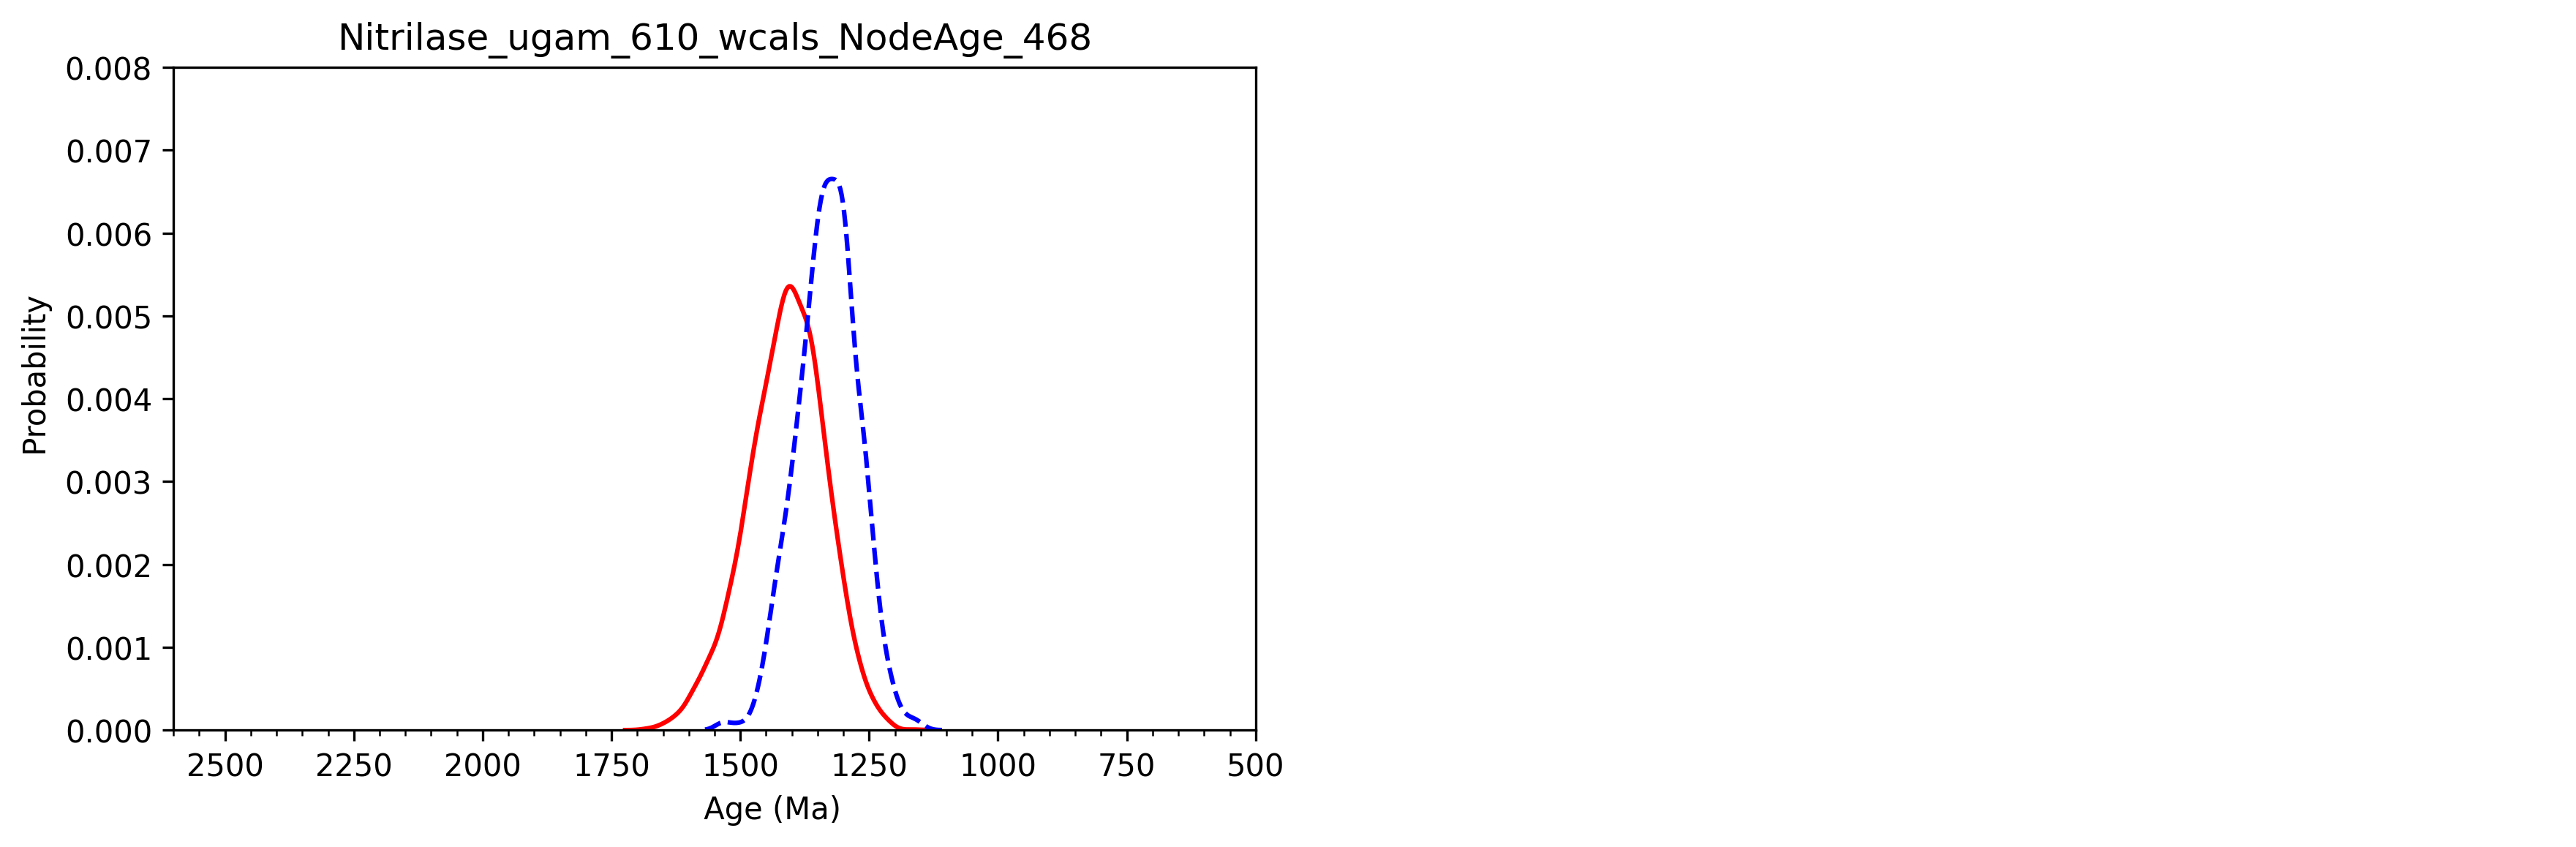

In [51]:
kwargs = {"linewidth" : "1.5"}
fig, axes = plt.subplots(1, 2, figsize=(14,4), sharex=False,sharey=True,dpi=300)

axes[0]=sns.kdeplot(Nitrilase_ugam_610_posterior_withcals_sample_ages['468'][0],label="Node ",
                    ax=axes[0],color="red", **kwargs)
axes[0]=sns.kdeplot(Nitrilase_ugam_610_prior_withcals_sample_ages['468'][0],label="Node ",
                    ax=axes[0],color="blue",linestyle='--', **kwargs)

axes[0].set_ylabel("     Probability")
axes[0].set_xlabel("             Age (Ma) ")

### Y-limits 
axes[0].set_ylim([0,0.008])
### X-limits 
axes[0].set_xlim([2600,500])
axes[0].xaxis.set_minor_locator(MultipleLocator(50))
axes[0].xaxis.set_major_locator(MultipleLocator(250))
axes[1].axis('off')
axes[0].title.set_text('Nitrilase_ugam_610_wcals_NodeAge_468')
fig.savefig('Nitrilase_ugam_610_wcals_NodeAge_468_10_16_22'+'.svg',format='svg')
fig.savefig('Nitrilase_ugam_610_wcals_NodeAge_468_10_16_22'+'.png',format='png')

In [52]:
########
#
#   
#
########

In [53]:
##################################################
# Original scheme w/ 3 models, posterior & prior #
##################################################

In [54]:
#####################
### Combined plot ### 
#####################

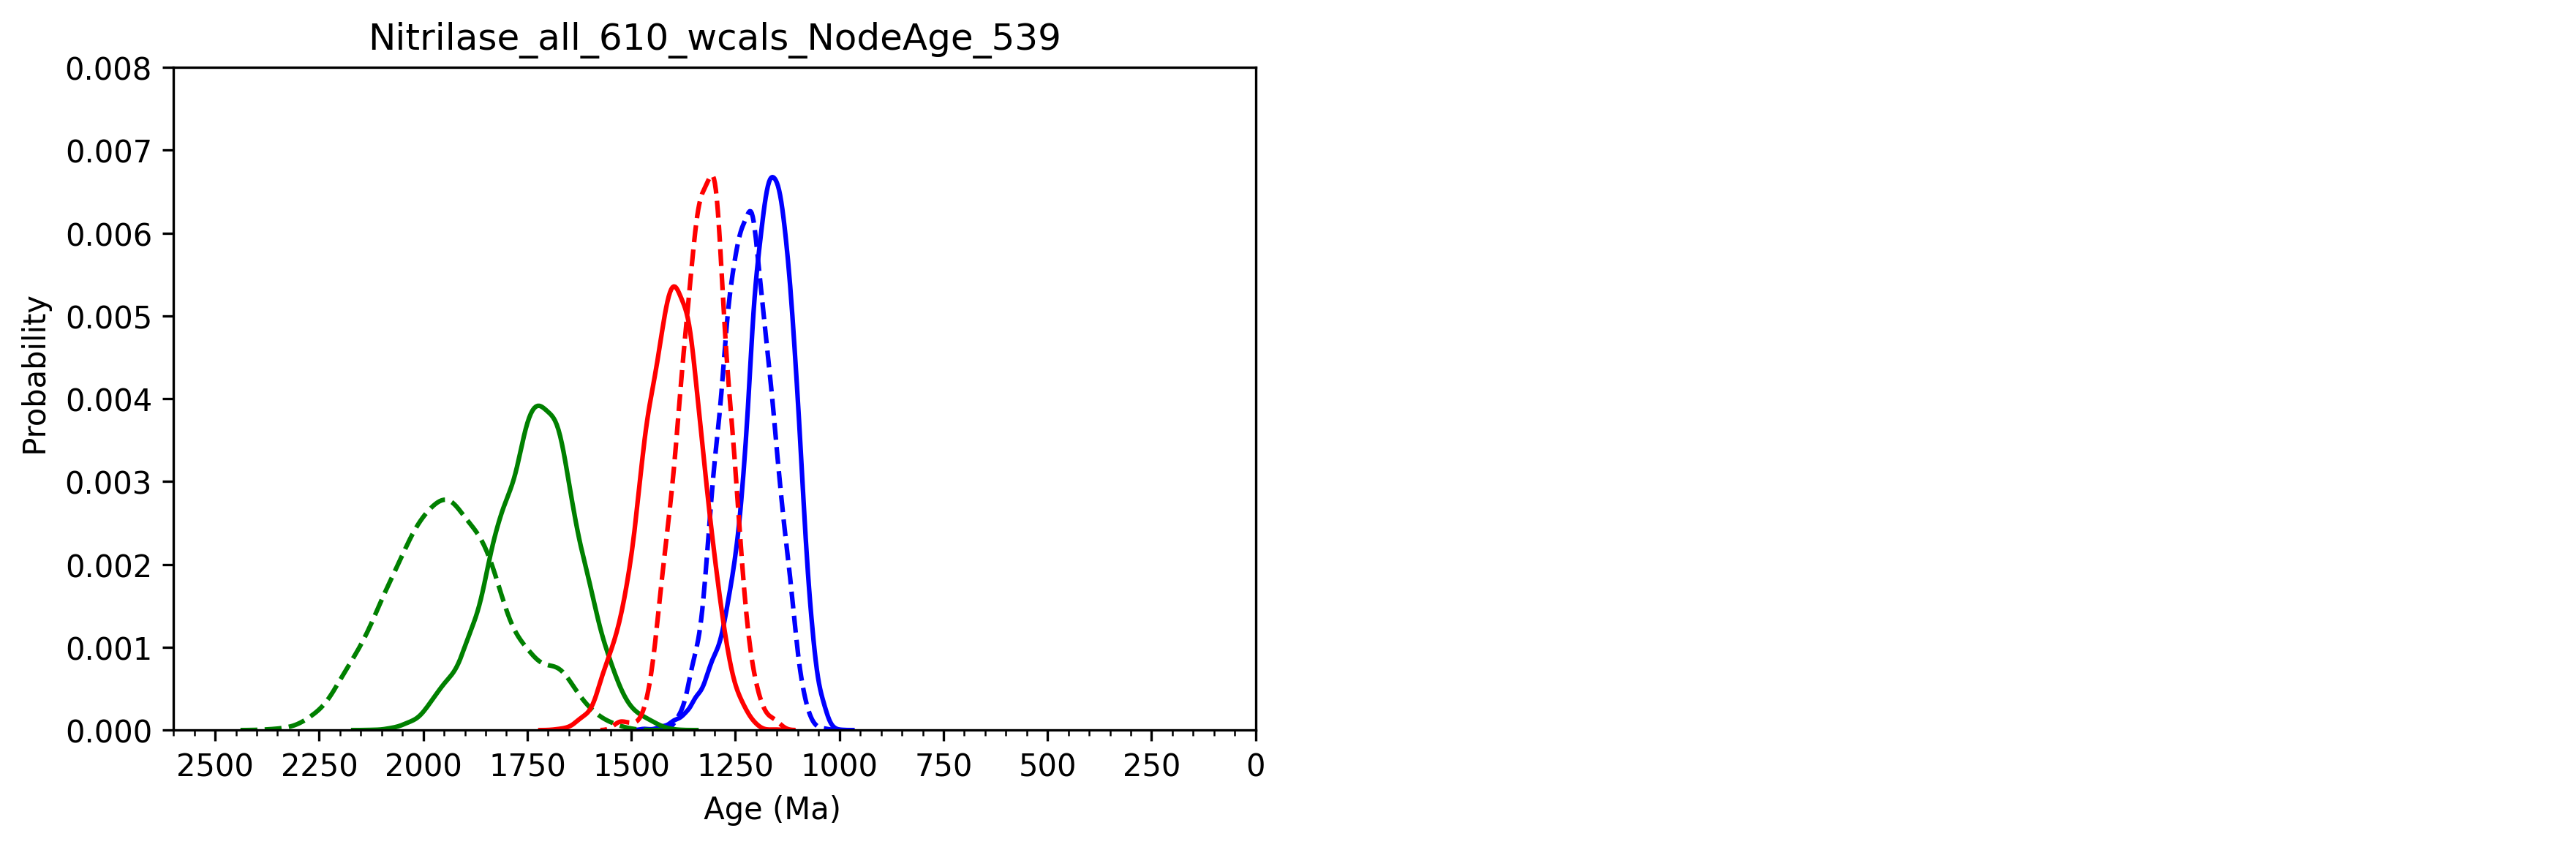

In [55]:
### Node#539
kwargs = {"linewidth" : "1.5"}
fig, axes = plt.subplots(1, 2, figsize=(14,4), sharex=False,sharey=True,dpi=300)

axes[0]=sns.kdeplot(Nitrilase_cir_610_posterior_wcals_ages['539'][0],label="Node ",
                    ax=axes[0],color="blue", **kwargs)
axes[0]=sns.kdeplot(Nitrilase_cir_610_prior_wcals_ages['539'][0],label="Node ",
                    ax=axes[0],color="blue",linestyle='--', **kwargs)

axes[0]=sns.kdeplot(Nitrilase_ln_610_posterior_wcals_sample_ages['539'][0],label="Node ",
                    ax=axes[0],color="green", **kwargs)
axes[0]=sns.kdeplot(Nitrilase_ln_610_prior_wcals_sample_ages['539'][0],label="Node ",
                    ax=axes[0],color="green",linestyle='--', **kwargs)

axes[0]=sns.kdeplot(Nitrilase_ugam_610_posterior_withcals_sample_ages['539'][0],label="Node ",
                    ax=axes[0],color="red", **kwargs)
axes[0]=sns.kdeplot(Nitrilase_ugam_610_prior_withcals_sample_ages['539'][0],label="Node ",
                    ax=axes[0],color="red",linestyle='--', **kwargs)

axes[0].set_ylabel("     Probability")
axes[0].set_xlabel("             Age (Ma) ")

### Y-limits 
axes[0].set_ylim([0,0.008])
### X-limits 
axes[0].set_xlim([2600,0])
axes[0].xaxis.set_minor_locator(MultipleLocator(50))
axes[0].xaxis.set_major_locator(MultipleLocator(250))
axes[1].axis('off')
axes[0].title.set_text('Nitrilase_all_610_wcals_NodeAge_539')
fig.savefig('Nitrilase_all_610_wcals_NodeAge_539_10_16_22'+'.svg',format='svg')
fig.savefig('Nitrilase_all_610_wcals_NodeAge_539_10_16_22'+'.png',format='png')

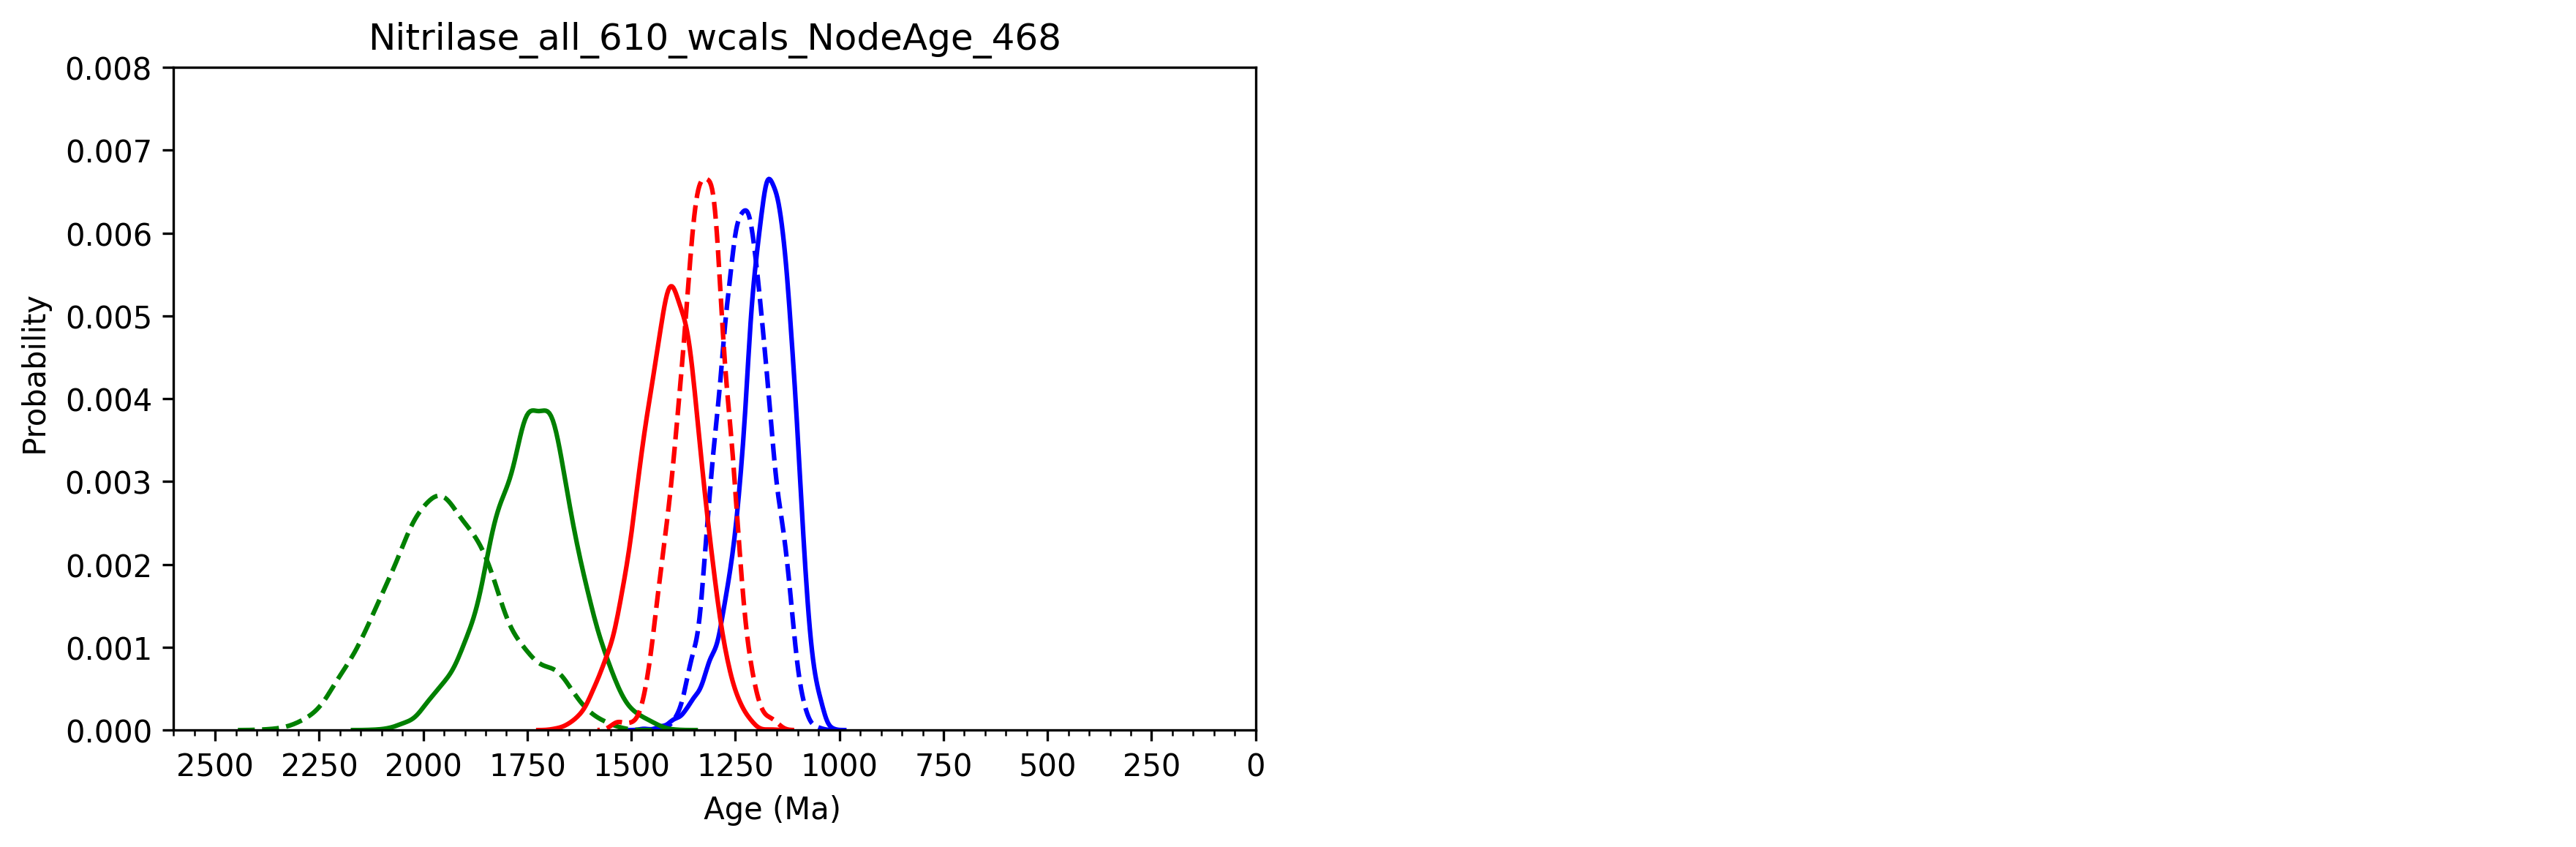

In [56]:
### Node#468
kwargs = {"linewidth" : "1.5"}
fig, axes = plt.subplots(1, 2, figsize=(14,4), sharex=False,sharey=True,dpi=300)

axes[0]=sns.kdeplot(Nitrilase_cir_610_posterior_wcals_ages['468'][0],label="Node ",
                    ax=axes[0],color="blue", **kwargs)
axes[0]=sns.kdeplot(Nitrilase_cir_610_prior_wcals_ages['468'][0],label="Node ",
                    ax=axes[0],color="blue",linestyle='--', **kwargs)

axes[0]=sns.kdeplot(Nitrilase_ln_610_posterior_wcals_sample_ages['468'][0],label="Node ",
                    ax=axes[0],color="green", **kwargs)
axes[0]=sns.kdeplot(Nitrilase_ln_610_prior_wcals_sample_ages['468'][0],label="Node ",
                    ax=axes[0],color="green",linestyle='--', **kwargs)

axes[0]=sns.kdeplot(Nitrilase_ugam_610_posterior_withcals_sample_ages['468'][0],label="Node ",
                    ax=axes[0],color="red", **kwargs)
axes[0]=sns.kdeplot(Nitrilase_ugam_610_prior_withcals_sample_ages['468'][0],label="Node ",
                    ax=axes[0],color="red",linestyle='--', **kwargs)

axes[0].set_ylabel("     Probability")
axes[0].set_xlabel("             Age (Ma) ")

### Y-limits 
axes[0].set_ylim([0,0.008])
### X-limits -- N.B. watch out for custom tick labels, they would have to be hard coded
axes[0].set_xlim([2600,0])
axes[0].xaxis.set_minor_locator(MultipleLocator(50))
axes[0].xaxis.set_major_locator(MultipleLocator(250))
axes[1].axis('off')
axes[0].title.set_text('Nitrilase_all_610_wcals_NodeAge_468')
fig.savefig('Nitrilase_all_610_wcals_NodeAge_468_10_16_22'+'.svg',format='svg')
fig.savefig('Nitrilase_all_610_wcals_NodeAge_468_10_16_22'+'.png',format='png')

In [57]:
### Saving routine

In [58]:
# Save to Disk
pd.DataFrame(Nitrilase_cir_610_posterior_wcals_ages['539']
            ).to_csv('Node_Age_Table_Node539_Nitrilase_cir_610_posterior_wcals.csv')

In [59]:
# Save to Disk
pd.DataFrame(Nitrilase_cir_610_posterior_wcals_ages['468']
            ).to_csv('Node_Age_Table_Node468_Nitrilase_cir_610_posterior_wcals.csv')

In [60]:
#Posterior Age Statistics for CIR for Nitrilase_cir_610_posterior_wcals_ages
print('Posterior Sample')
print('Len:',len(Nitrilase_cir_610_posterior_wcals_ages['468'][0]))
for name in ['468','539']: #change this loop to be all: internal_node_names
    node_name_print=str(name)
    print('Node',node_name_print)
    print('Mean',np.mean(Nitrilase_cir_610_posterior_wcals_ages[node_name_print][0])) #Mean
    print('Median',np.median(Nitrilase_cir_610_posterior_wcals_ages[node_name_print][0])) #Median
    print('Recent HDI',arviz.hdi(np.array(Nitrilase_cir_610_posterior_wcals_ages[node_name_print][0]),hdi_prob=0.95)[0]) #Recent Bound - HDI
    print('Ancient HDI',arviz.hdi(np.array(Nitrilase_cir_610_posterior_wcals_ages[node_name_print][0]),hdi_prob=0.95)[1]) #Ancient Bound - HD

Posterior Sample
Len: 16960
Node 468
Mean 1178.4501491745282
Median 1172.205
Recent HDI 1065.91
Ancient HDI 1312.97
Node 539
Mean 1172.7182052476414
Median 1166.47
Recent HDI 1058.72
Ancient HDI 1306.42


In [61]:
########################
### d_Nitrilase_MODEL ##
########################

In [62]:
#####################
### Combined plot ### 
#####################

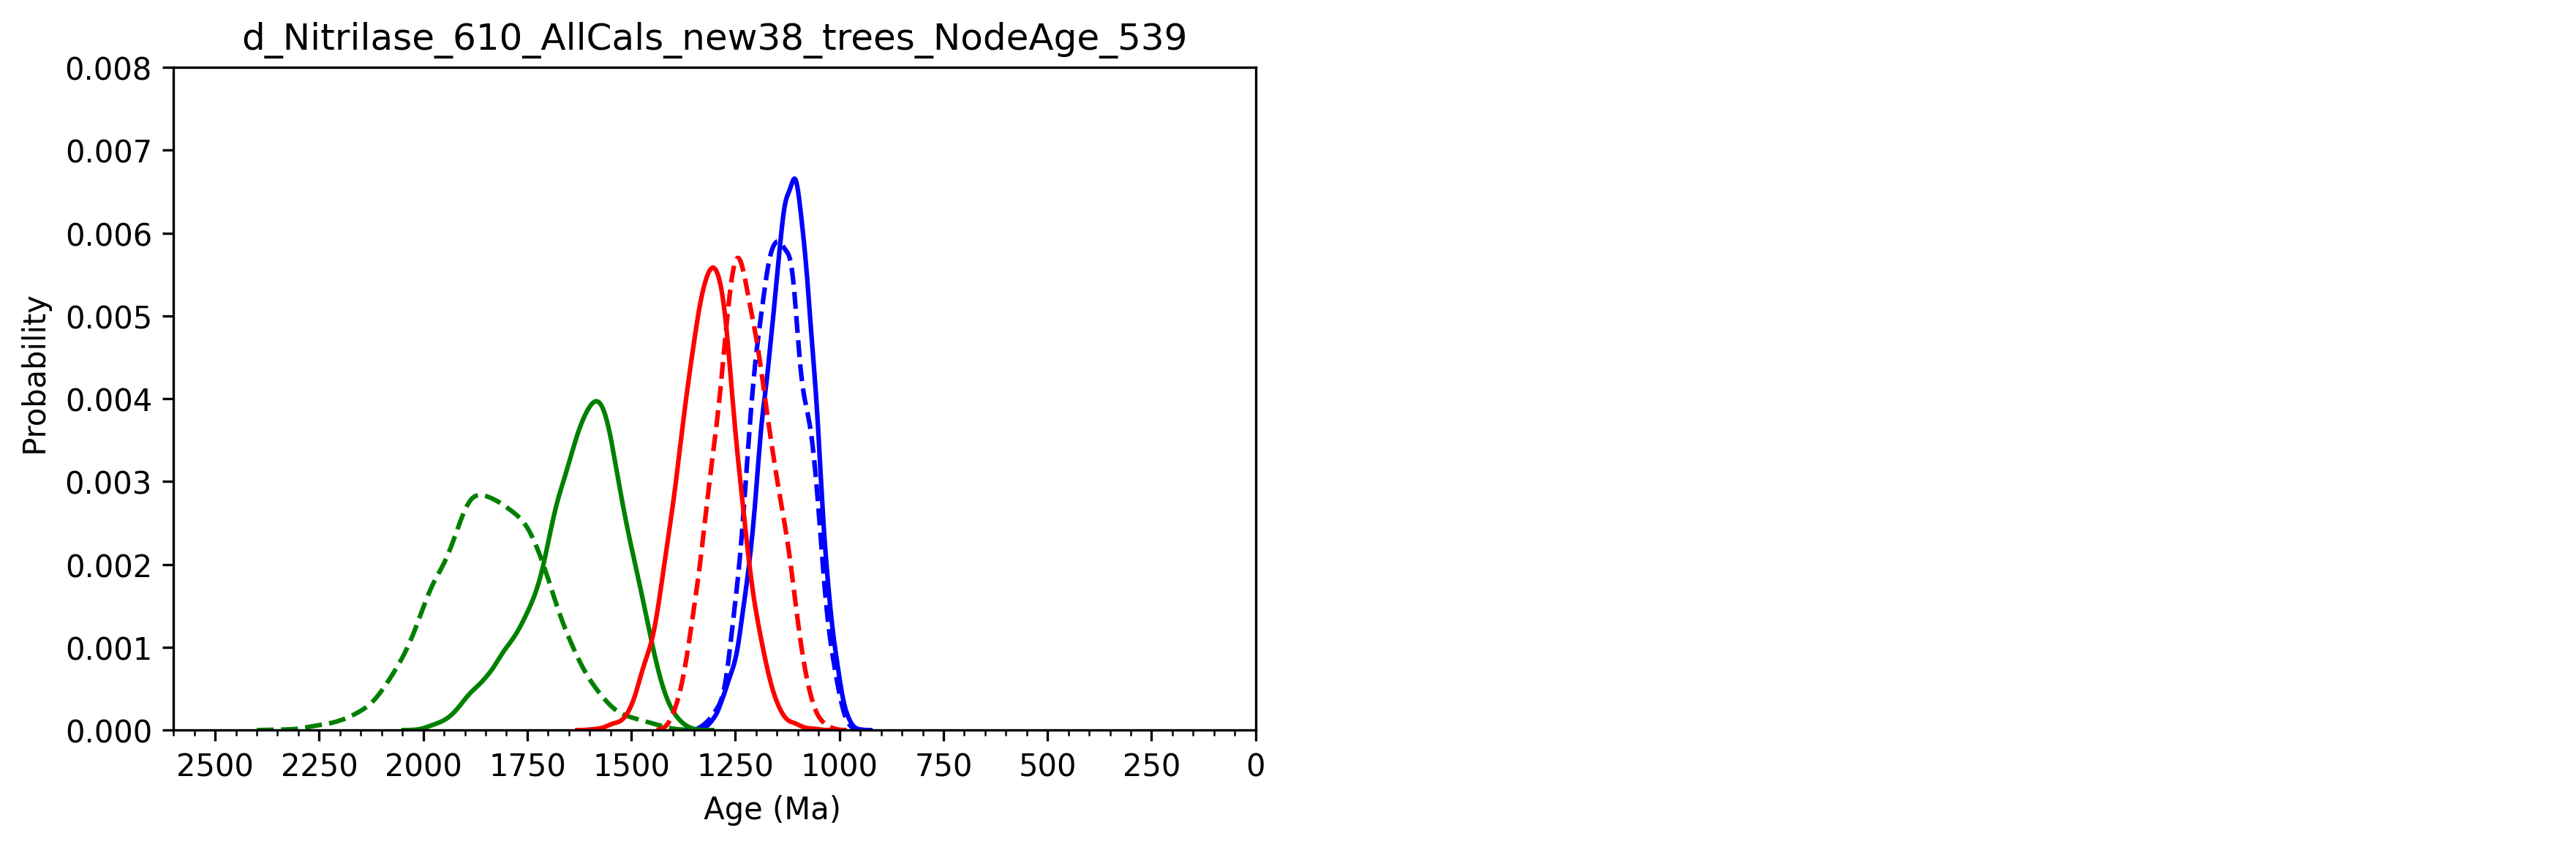

In [63]:
### Node#539
kwargs = {"linewidth" : "1.5"}
fig, axes = plt.subplots(1, 2, figsize=(14,4), sharex=False,sharey=True,dpi=300)

axes[0]=sns.kdeplot(d_Nitrilase_cir_610_post_AllCals_new38_sample_ages['539'][0],label="Node ",
                    ax=axes[0],color="blue", **kwargs)
axes[0]=sns.kdeplot(d_Nitrilase_cir_610_prior_AllCals_new38_sample_ages['539'][0],label="Node ",
                    ax=axes[0],color="blue",linestyle='--', **kwargs)

axes[0]=sns.kdeplot(d_Nitrilase_ln_610_post_AllCals_new38_sample_ages['539'][0],label="Node ",
                    ax=axes[0],color="green", **kwargs)
axes[0]=sns.kdeplot(d_Nitrilase_ln_610_prior_AllCals_new38_sample_ages['539'][0],label="Node ",
                    ax=axes[0],color="green",linestyle='--', **kwargs)

axes[0]=sns.kdeplot(d_Nitrilase_ugam_610_post_AllCals_new38_sample_ages['539'][0],label="Node ",
                    ax=axes[0],color="red", **kwargs)
axes[0]=sns.kdeplot(d_Nitrilase_ugam_610_prior_AllCals_new38_sample_ages['539'][0],label="Node ",
                    ax=axes[0],color="red",linestyle='--', **kwargs)

axes[0].set_ylabel("     Probability")
axes[0].set_xlabel("             Age (Ma) ")

### Y-limits 
axes[0].set_ylim([0,0.008])
### X-limits 
axes[0].set_xlim([2600,0])
axes[0].xaxis.set_minor_locator(MultipleLocator(50))
axes[0].xaxis.set_major_locator(MultipleLocator(250))
axes[1].axis('off')
axes[0].title.set_text('d_Nitrilase_610_AllCals_new38_trees_NodeAge_539')
fig.savefig('d_Nitrilase_610_AllCals_new38_trees_NodeAge_539_10_16_22'+'.svg',format='svg')
fig.savefig('d_Nitrilase_610_AllCals_new38_trees_NodeAge_539_10_16_22'+'.png',format='png')

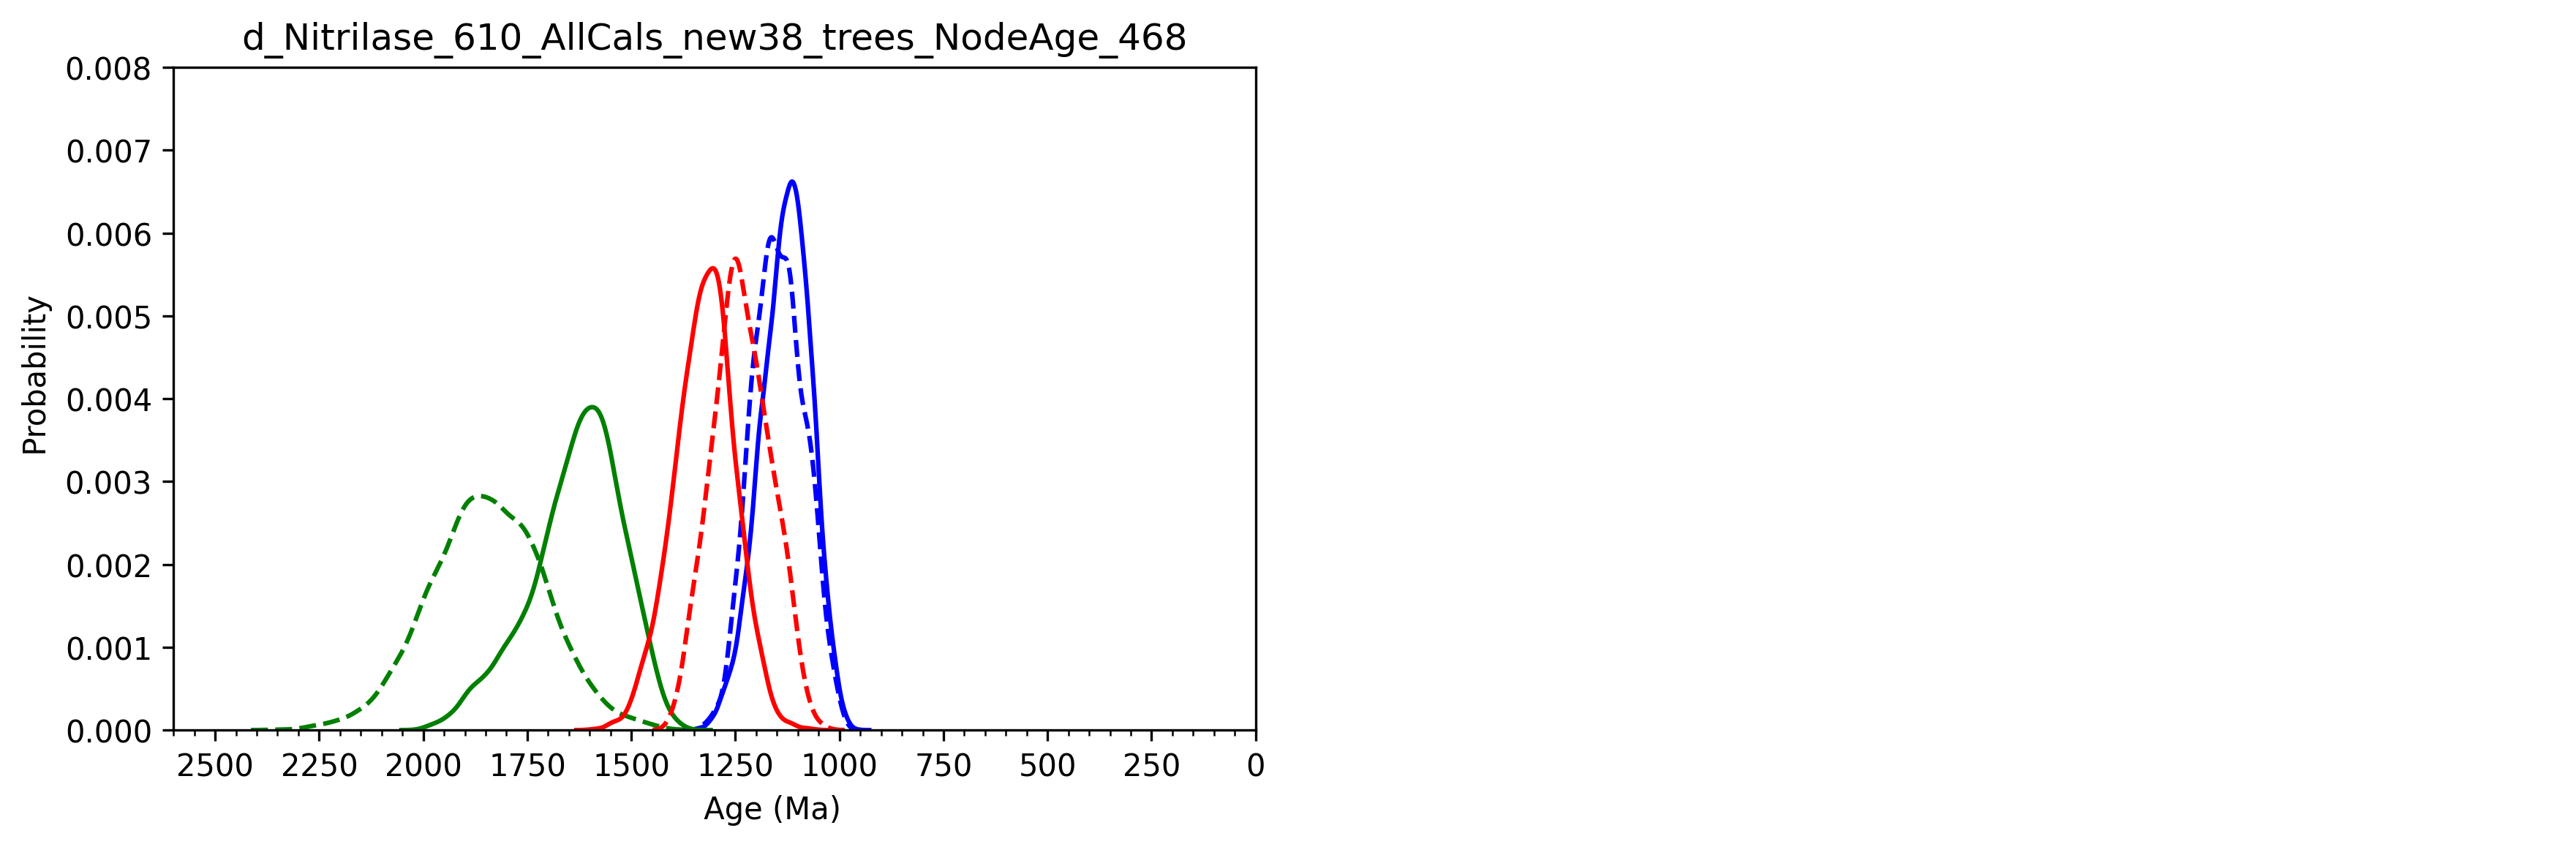

In [64]:
### Node#468
kwargs = {"linewidth" : "1.5"}
fig, axes = plt.subplots(1, 2, figsize=(14,4), sharex=False,sharey=True,dpi=300)

axes[0]=sns.kdeplot(d_Nitrilase_cir_610_post_AllCals_new38_sample_ages['468'][0],label="Node ",
                    ax=axes[0],color="blue", **kwargs)
axes[0]=sns.kdeplot(d_Nitrilase_cir_610_prior_AllCals_new38_sample_ages['468'][0],label="Node ",
                    ax=axes[0],color="blue",linestyle='--', **kwargs)

axes[0]=sns.kdeplot(d_Nitrilase_ln_610_post_AllCals_new38_sample_ages['468'][0],label="Node ",
                    ax=axes[0],color="green", **kwargs)
axes[0]=sns.kdeplot(d_Nitrilase_ln_610_prior_AllCals_new38_sample_ages['468'][0],label="Node ",
                    ax=axes[0],color="green",linestyle='--', **kwargs)

axes[0]=sns.kdeplot(d_Nitrilase_ugam_610_post_AllCals_new38_sample_ages['468'][0],label="Node ",
                    ax=axes[0],color="red", **kwargs)
axes[0]=sns.kdeplot(d_Nitrilase_ugam_610_prior_AllCals_new38_sample_ages['468'][0],label="Node ",
                    ax=axes[0],color="red",linestyle='--', **kwargs)

axes[0].set_ylabel("     Probability")
axes[0].set_xlabel("             Age (Ma) ")

### Y-limits 
axes[0].set_ylim([0,0.008])
### X-limits 
axes[0].set_xlim([2600,0])
axes[0].xaxis.set_minor_locator(MultipleLocator(50))
axes[0].xaxis.set_major_locator(MultipleLocator(250))
axes[1].axis('off')
axes[0].title.set_text('d_Nitrilase_610_AllCals_new38_trees_NodeAge_468')
fig.savefig('d_Nitrilase_610_AllCals_new38_trees_NodeAge_468_10_16_22'+'.svg',format='svg')
fig.savefig('d_Nitrilase_610_AllCals_new38_trees_NodeAge_468_10_16_22'+'.png',format='png')

In [65]:
# Save to Disk
pd.DataFrame(d_Nitrilase_cir_610_post_AllCals_new38_sample_ages['468']
            ).to_csv('Node_Age_Table_Node468_d_Nitrilase_cir_610_post_AllCals_new38_sample_ages.csv')

In [66]:
# Save to Disk
pd.DataFrame(d_Nitrilase_cir_610_post_AllCals_new38_sample_ages['539']
            ).to_csv('Node_Age_Table_Node539_d_Nitrilase_cir_610_post_AllCals_new38_sample_ages.csv')

In [67]:
#Posterior Age Statistics for CIR for d_Nitrilase_cir_610_posterior_wcals_ages
print('Posterior Sample')
print('Len:',len(d_Nitrilase_cir_610_post_AllCals_new38_sample_ages[node_name_print][0]))
for name in ['468','539']: #change this loop to be all: internal_node_names
    node_name_print=str(name)
    print('Node',node_name_print)
    print('Mean',np.mean(d_Nitrilase_cir_610_post_AllCals_new38_sample_ages[node_name_print][0])) #Mean
    print('Median',np.median(d_Nitrilase_cir_610_post_AllCals_new38_sample_ages[node_name_print][0])) #Median
    print('Recent HDI',arviz.hdi(np.array(d_Nitrilase_cir_610_post_AllCals_new38_sample_ages[node_name_print][0]),hdi_prob=0.95)[0]) #Recent Bound - HDI
    print('Ancient HDI',arviz.hdi(np.array(Nitrilase_cir_610_posterior_wcals_ages[node_name_print][0]),hdi_prob=0.95)[1]) #Ancient Bound - HD

Posterior Sample
Len: 26160
Node 468
Mean 1129.0596765672783
Median 1125.05
Recent HDI 1011.68
Ancient HDI 1312.97
Node 539
Mean 1124.994564525994
Median 1121.38
Recent HDI 1011.18
Ancient HDI 1306.42


In [68]:
########################
#
#   End of Figures
#
########################

In [ ]:
####################################################################################################
#  WARNING THESE TAKE A VERY LONG TIME AND RAM TO RUN -- ONLY NEED TO DO THIS ONCE
#   First trees are loaded as an ete3 multitree object, from datedist file of chronograms
#    Ages are grabbed from data based on hardcoded internal node labels with getAges function
#     A PICKLE OBJECT WILL BE WRITTEN TO DISK YOU CAN CALL WITH loadAges!
#      N.B. Hard coded to only get certain nodes!!!
#####################################################################################################

In [ ]:
##################################################
# Original scheme w/ 3 models, posterior & prior #
##################################################

In [ ]:
Nitrilase_cir_610_prior_wcals_trees = [ete3.Tree(line) 
                      for line in open('Nitrilase_cir_610_prior_wcals_sample.datedist').readlines()]

In [ ]:
Nitrilase_cir_610_prior_wcals_ages = getAges(Nitrilase_cir_610_prior_wcals_trees,
                                            'Nitrilase_cir_610_prior_wcals_sample')

In [ ]:
Nitrilase_cir_610_posterior_wcals_trees = [ete3.Tree(line) 
                      for line in open('Nitrilase_cir_610_posterior_wcals_sample.datedist').readlines()]

In [ ]:
Nitrilase_cir_610_posterior_wcals_ages = getAges(Nitrilase_cir_610_posterior_wcals_trees,
                                                 'Nitrilase_cir_610_posterior_wcals_sample')

In [ ]:
Nitrilase_ln_610_prior_wcals_trees = [ete3.Tree(line) 
                      for line in open('Nitrilase_ln_610_prior_wcals_sample.datedist').readlines()]

In [ ]:
Nitrilase_ln_610_prior_wcals_sample_ages = getAges(Nitrilase_ln_610_prior_wcals_trees,
                                                   'Nitrilase_ln_610_prior_wcals_sample')

In [ ]:
Nitrilase_ln_610_posterior_wcals_trees = [ete3.Tree(line) 
                      for line in open('Nitrilase_ln_610_posterior_wcals_sample.datedist').readlines()]

In [ ]:
Nitrilase_ln_610_posterior_wcals_sample_ages = getAges(Nitrilase_ln_610_posterior_wcals_trees,
                                                       'Nitrilase_ln_610_posterior_wcals_sample')

In [ ]:
Nitrilase_ugam_610_prior_withcals_trees = [ete3.Tree(line) 
                      for line in open('Nitrilase_ugam_610_prior_withcals_sample.datedist').readlines()]

In [ ]:
Nitrilase_ugam_610_prior_withcals_sample_ages = getAges(Nitrilase_ugam_610_prior_withcals_trees,
                                                        'Nitrilase_ugam_610_prior_withcals_sample')

In [ ]:
Nitrilase_ugam_610_posterior_withcals_trees = [ete3.Tree(line) 
                      for line in open('Nitrilase_ugam_610_posterior_withcals_sample.datedist').readlines()]

In [ ]:
Nitrilase_ugam_610_posterior_withcals_sample_ages = getAges(Nitrilase_ugam_610_posterior_withcals_trees,
                                                            'Nitrilase_ugam_610_posterior_withcals_sample')

In [ ]:
########
#
#   
#
########

In [ ]:
####################################################################################################
#  WARNING THESE TAKE A VERY LONG TIME AND RAM TO RUN -- ONLY NEED TO DO THIS ONCE
#   First trees are loaded as an ete3 multitree object, from datedist file of chronograms
#    Ages are grabbed from data based on hardcoded internal node labels with getAges function
#     A PICKLE OBJECT WILL BE WRITTEN TO DISK YOU CAN CALL WITH loadAges!
#      N.B. Hard coded to only get certain nodes!!!
####################################################################################################

In [ ]:
########################
# NEW CLOCK MODEL "d_" #
########################

In [ ]:
d_Nitrilase_cir_610_prior_AllCals_new38_trees = [ete3.Tree(line) 
                      for line in open('d_Nitrilase_cir_610_prior_AllCals_new38_sample.datedist').readlines()]

In [ ]:
d_Nitrilase_cir_610_prior_AllCals_new38_sample_ages = getAges(d_Nitrilase_cir_610_prior_AllCals_new38_trees,
                                                            'd_Nitrilase_cir_610_prior_AllCals_new38_sample')

In [ ]:
d_Nitrilase_cir_610_post_AllCals_new38_trees = [ete3.Tree(line) 
                      for line in open('d_Nitrilase_cir_610_post_AllCals_new38_sample.datedist').readlines()]

In [ ]:
d_Nitrilase_cir_610_post_AllCals_new38_sample_ages = getAges(d_Nitrilase_cir_610_post_AllCals_new38_trees,
                                                            'd_Nitrilase_cir_610_post_AllCals_new38_sample')

In [ ]:
d_Nitrilase_ln_610_prior_AllCals_new38_trees = [ete3.Tree(line) 
                      for line in open('d_Nitrilase_ln_610_prior_AllCals_new38_sample.datedist').readlines()]

In [ ]:
d_Nitrilase_ln_610_prior_AllCals_new38_sample_ages = getAges(d_Nitrilase_ln_610_prior_AllCals_new38_trees,
                                                            'd_Nitrilase_ln_610_prior_AllCals_new38_sample')

In [ ]:
d_Nitrilase_ln_610_post_AllCals_new38_trees = [ete3.Tree(line) 
                      for line in open('d_Nitrilase_ln_610_post_AllCals_new38_sample.datedist').readlines()]

In [ ]:
d_Nitrilase_ln_610_post_AllCals_new38_sample_ages = getAges(d_Nitrilase_ln_610_post_AllCals_new38_trees,
                                                            'd_Nitrilase_ln_610_post_AllCals_new38_sample')

In [ ]:
d_Nitrilase_ugam_610_prior_AllCals_new38_trees = [ete3.Tree(line) 
                      for line in open('d_Nitrilase_ugam_610_prior_AllCals_new38_sample.datedist').readlines()]

In [ ]:
d_Nitrilase_ugam_610_prior_AllCals_new38_sample_ages = getAges(d_Nitrilase_ugam_610_prior_AllCals_new38_trees,
                                                            'd_Nitrilase_ugam_610_prior_AllCals_new38_sample')

In [ ]:
d_Nitrilase_ugam_610_post_AllCals_new38_trees = [ete3.Tree(line) 
                      for line in open('d_Nitrilase_ugam_610_post_AllCals_new38_sample.datedist').readlines()]

In [ ]:
d_Nitrilase_ugam_610_post_AllCals_new38_sample_ages = getAges(d_Nitrilase_ugam_610_post_AllCals_new38_trees,
                                                            'd_Nitrilase_ugam_610_post_AllCals_new38_sample')

In [ ]:
########
#
#   
#
########

In [ ]:
### END ###